# **Dressing Up My Virtual Friends: An ACNH Clothing Recommender**

One of my favorite games is Nintendo's Animal Crossing: New Horizons (ACNH) and have invested nearly 500 hours in the game. In ACNH, players begin on a mostly barren island with the objective of transforming it into a thriving village populated by charming animal residents. To attract and befriend these villagers, players can offer gifts like furniture, caught fish or bugs, and, my personal favorite, clothing! Each villager has a unique personality that influences their preferences in speech, hobbies, and preferred items. By giving them items they like, players can enhance their friendship levels. Due to the extensive variety of villagers available, I enjoy curating an island populated with my favorite villagers and building strong connections with them. However, choosing the right gifts can be challenging, as what you think a villager will like might not always align with their preferences. To address this, I plan to to create a clothing recommendation system for my virtual friends. This way, I can consistently gift them items that match their tastes and enhance our in-game friendships!

The datasets I've selected contain detailed information about each villager and the diverse clothing items they can wear. There is a dataset for all villagers in ACNH where each row represents a villager with columns such as clothing they own, furniture they own, their favorite styles and colors, their catchphrases, etc. There are also 4 additional individual datasets for each category of clothing. Each clothing dataset has details about what style a clothing article is considered, what colors they are, if it's villager equippable (because the player themselves can wear clothes that villagers cannot, so this distinction is important), the unique clothing_id (also important because there can be the same clothing item in multiple colors, so using clothing name would be difficult to distinguish), etc. It should also be noted that in the game, clothing items are gender free, so gender of the villagers don't have to be considered.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [3]:
# URLs for all clothing item CSVs
urls = [
    'https://raw.githubusercontent.com/yepzoey/dsc207finalproject/main/datasets/clothing_items/accessories.csv',
    'https://raw.githubusercontent.com/yepzoey/dsc207finalproject/main/datasets/clothing_items/dress-up.csv',
    'https://raw.githubusercontent.com/yepzoey/dsc207finalproject/main/datasets/clothing_items/headwear.csv',
    'https://raw.githubusercontent.com/yepzoey/dsc207finalproject/main/datasets/clothing_items/tops.csv'
]

# Initialize an empty list to store DataFrames
dfs = []

# Loop through each URL
for url in urls:
    # Read the CSV content directly into a DataFrame from the URL
    category_df = pd.read_csv(url)
    
    # Add a 'Category' column to distinguish different types of clothing items
    category_df['Category'] = url.split('/')[-1].split('.')[0]  # Extract the category from the URL

    # Append the category DataFrame to the list
    dfs.append(category_df)

# Concatenate all DataFrames in the list into one
clothing_items_df = pd.concat(dfs, ignore_index=True)

# Create new column combining overall style and color preferences
clothing_items_df['overall_style'] = clothing_items_df['Style 1'] + '_' + clothing_items_df['Style 2']
clothing_items_df['overall_color'] = clothing_items_df['Color 1'] + '_' + clothing_items_df['Color 2']

# Select specific columns
selected_columns = [
    'Name', 'Category', 'Variation', 'Style 1', 'Style 2', 'overall_style', 'Color 1', 'Color 2',  'overall_color', 'Villager Equippable', 'Internal ID'
]

# Keep only the selected columns
clothing_items_df = clothing_items_df[selected_columns]

# Remove rows where "Villager Equippable" is set to "No"
clothing_items_df = clothing_items_df[clothing_items_df['Villager Equippable'] == 'Yes']

# Reset the index
clothing_items_df = clothing_items_df.reset_index(drop=True)

# Check the structure of the combined DataFrame
clothing_items_df

,Name,Category,Variation,Style 1,Style 2,overall_style,Color 1,Color 2,overall_color,Villager Equippable,Internal ID
0,3D glasses,accessories,White,Active,Active,Active_Active,White,Colorful,White_Colorful,Yes,4463
1,3D glasses,accessories,Black,Active,Active,Active_Active,Black,Colorful,Black_Colorful,Yes,11020
2,animal nose,accessories,NaN,Cute,Cute,Cute_Cute,Black,Black,Black_Black,Yes,13018
3,ballroom mask,accessories,White,Elegant,Elegant,Elegant_Elegant,White,White,White_White,Yes,4561
4,ballroom mask,accessories,Black,Elegant,Elegant,Elegant_Elegant,Black,Black,Black_Black,Yes,11159
...,...,...,...,...,...,...,...,...,...,...,...
3222,zen uniform,tops,Golden yellow,Cool,Simple,Cool_Simple,Yellow,Blue,Yellow_Blue,Yes,14954
3223,zen uniform,tops,Green,Cool,Simple,Cool_Simple,Green,Beige,Green_Beige,Yes,14955
3224,zen uniform,tops,Blue,Cool,Simple,Cool_Simple,Blue,Gray,Blue_Gray,Yes,14953
3225,zen uniform,tops,Purple,Cool,Simple,Cool_Simple,Purple,Black,Purple_Black,Yes,14956


__Vilagers DataFrame__

In [4]:
villagers_df = pd.read_csv('https://raw.githubusercontent.com/yepzoey/dsc207finalproject/main/datasets/villagers.csv')

# Create new column combining overall style and color preferences
villagers_df['overall_style'] = villagers_df['Style 1'] + '_' + villagers_df['Style 2']
villagers_df['overall_color'] = villagers_df['Color 1'] + '_' + villagers_df['Color 2']

# Select specific columns
selected_columns = ['Name', 'Gender', 'Personality', 'Hobby', 'Style 1', 'Style 2', 'overall_style', 'Color 1', 'Color 2', 'overall_color','Default Clothing', 'Unique Entry ID',]

# Keep only the selected columns
villagers_df = villagers_df[selected_columns]

villagers_df

,Name,Gender,Personality,Hobby,Style 1,Style 2,overall_style,Color 1,Color 2,overall_color,Default Clothing,Unique Entry ID
0,Ace,Male,Jock,Nature,Active,Cute,Active_Cute,Aqua,Green,Aqua_Green,9132,cBJxF2eoM4Cymei82
1,Admiral,Male,Cranky,Nature,Cool,Cool,Cool_Cool,Black,Blue,Black_Blue,3164,B3RyfNEqwGmcccRC3
2,Agent S,Female,Peppy,Fitness,Active,Simple,Active_Simple,Blue,Black,Blue_Black,12036,SGMdki6dzpDZyXAw5
3,Agnes,Female,Big Sister,Play,Simple,Elegant,Simple_Elegant,Pink,White,Pink_White,4290,jzWCiDPm9MqtCfecP
4,Al,Male,Lazy,Fitness,Active,Active,Active_Active,Red,White,Red_White,3244,LBifxETQJGEaLhBjC
...,...,...,...,...,...,...,...,...,...,...,...,...
408,Wolfgang,Male,Cranky,Education,Cool,Active,Cool_Active,Black,Green,Black_Green,4207,RbF2wcn6jRxtgLDRd
409,Yuka,Female,Snooty,Fashion,Cool,Elegant,Cool_Elegant,Orange,Yellow,Orange_Yellow,7676,QDcxk3dCNT6yeD9hk
410,Zell,Male,Smug,Music,Cool,Gorgeous,Cool_Gorgeous,Purple,Gray,Purple_Gray,3676,LodBWtdMRZbjFNga9
411,Zoe,Female,Normal,Education,Cute,Simple,Cute_Simple,Pink,White,Pink_White,3248,oypQcviP2QAkFYFaJ


## **Data Quality, Initial Processing**

There were some NaN/null values in the 'variation' column of the clothing_items_df DataFrame. This is because these clothing items don't come in various colors and thus, don't have a variation.

However, other than that, there's no quality issues with the villagers_df or clothing_items_df DataFrames.

Some preprocessing steps that I took at the very beginning were lowercasing all the column names and replacing the spaces with underscores for both my villagers_df and clothing_items_df DataFrames. This was mainly for consistency and ease of access. 

I also went ahead and renamed 'internal_id' to 'clothing_id' in clothing_items_df, as well as renamed 'unique_entry_id' to 'user_id' in villagers_df so that these column names are more descriptive of their contents.

To address the quality issues in the dataset, I replaced NaN values in the 'variation' column of the clothing_items_df DataFrame with the string "No Variation". This is homogenous with the rest of the values in that column as they are all objects (not integers or floats).


In [6]:
# Lowercase column names and replace spaces
clothing_items_df.columns = clothing_items_df.columns.str.lower().str.replace(' ','_')

clothing_items_df.columns

Index(['name', 'category', 'variation', 'style_1', 'style_2', 'overall_style',
       'color_1', 'color_2', 'overall_color', 'villager_equippable',
       'internal_id'],
      dtype='object')

In [7]:
# Lowercase column names and replace spaces
villagers_df.columns = villagers_df.columns.str.lower().str.replace(' ','_')

villagers_df.columns

Index(['name', 'gender', 'personality', 'hobby', 'style_1', 'style_2',
       'overall_style', 'color_1', 'color_2', 'overall_color',
       'default_clothing', 'unique_entry_id'],
      dtype='object')

In [8]:
# Rename internal_id to clothing_id
clothing_items_df.rename(columns={'internal_id':'clothing_id'}, inplace=True)

clothing_items_df.head()

,name,category,variation,style_1,style_2,overall_style,color_1,color_2,overall_color,villager_equippable,clothing_id
0,3D glasses,accessories,White,Active,Active,Active_Active,White,Colorful,White_Colorful,Yes,4463
1,3D glasses,accessories,Black,Active,Active,Active_Active,Black,Colorful,Black_Colorful,Yes,11020
2,animal nose,accessories,NaN,Cute,Cute,Cute_Cute,Black,Black,Black_Black,Yes,13018
3,ballroom mask,accessories,White,Elegant,Elegant,Elegant_Elegant,White,White,White_White,Yes,4561
4,ballroom mask,accessories,Black,Elegant,Elegant,Elegant_Elegant,Black,Black,Black_Black,Yes,11159


In [9]:
villagers_df.rename(columns={'unique_entry_id':'user_id'}, inplace=True)

villagers_df.head()

,name,gender,personality,hobby,style_1,style_2,overall_style,color_1,color_2,overall_color,default_clothing,user_id
0,Ace,Male,Jock,Nature,Active,Cute,Active_Cute,Aqua,Green,Aqua_Green,9132,cBJxF2eoM4Cymei82
1,Admiral,Male,Cranky,Nature,Cool,Cool,Cool_Cool,Black,Blue,Black_Blue,3164,B3RyfNEqwGmcccRC3
2,Agent S,Female,Peppy,Fitness,Active,Simple,Active_Simple,Blue,Black,Blue_Black,12036,SGMdki6dzpDZyXAw5
3,Agnes,Female,Big Sister,Play,Simple,Elegant,Simple_Elegant,Pink,White,Pink_White,4290,jzWCiDPm9MqtCfecP
4,Al,Male,Lazy,Fitness,Active,Active,Active_Active,Red,White,Red_White,3244,LBifxETQJGEaLhBjC


In [10]:
# Check for duplicates, NaNs, data types in clothing_items_df
print("Duplicates:\n", clothing_items_df.duplicated().sum())
print("\nMissing Values:\n", clothing_items_df.isna().sum())
print("\nData Types:\n", clothing_items_df.dtypes)

# Replace NaN values in the 'variation' column with "No Variation"
clothing_items_df['variation'] = clothing_items_df['variation'].fillna("No Variation")
print("\nMissing Values Check:\n", clothing_items_df.isna().sum())

Duplicates:
 0

Missing Values:
 name                     0
category                 0
variation              256
style_1                  0
style_2                  0
overall_style            0
color_1                  0
color_2                  0
overall_color            0
villager_equippable      0
clothing_id              0
dtype: int64

Data Types:
 name                   object
category               object
variation              object
style_1                object
style_2                object
overall_style          object
color_1                object
color_2                object
overall_color          object
villager_equippable    object
clothing_id             int64
dtype: object

Missing Values Check:
 name                   0
category               0
variation              0
style_1                0
style_2                0
overall_style          0
color_1                0
color_2                0
overall_color          0
villager_equippable    0
clothing_id            0


In [11]:
clothing_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3227 entries, 0 to 3226
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   name                 3227 non-null   object
 1   category             3227 non-null   object
 2   variation            3227 non-null   object
 3   style_1              3227 non-null   object
 4   style_2              3227 non-null   object
 5   overall_style        3227 non-null   object
 6   color_1              3227 non-null   object
 7   color_2              3227 non-null   object
 8   overall_color        3227 non-null   object
 9   villager_equippable  3227 non-null   object
 10  clothing_id          3227 non-null   int64 
dtypes: int64(1), object(10)
memory usage: 277.4+ KB


In [12]:
# Check for duplicates, NaNs, data types in clothing_items_df
print("Duplicates:\n", villagers_df.duplicated().sum())
print("\nMissing Values:\n", villagers_df.isna().sum())
print("\nData Types:\n", villagers_df.dtypes)

Duplicates:
 0

Missing Values:
 name                0
gender              0
personality         0
hobby               0
style_1             0
style_2             0
overall_style       0
color_1             0
color_2             0
overall_color       0
default_clothing    0
user_id             0
dtype: int64

Data Types:
 name                object
gender              object
personality         object
hobby               object
style_1             object
style_2             object
overall_style       object
color_1             object
color_2             object
overall_color       object
default_clothing     int64
user_id             object
dtype: object


In [13]:
villagers_df['user_id'].nunique()

413

In [14]:
villagers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              413 non-null    object
 1   gender            413 non-null    object
 2   personality       413 non-null    object
 3   hobby             413 non-null    object
 4   style_1           413 non-null    object
 5   style_2           413 non-null    object
 6   overall_style     413 non-null    object
 7   color_1           413 non-null    object
 8   color_2           413 non-null    object
 9   overall_color     413 non-null    object
 10  default_clothing  413 non-null    int64 
 11  user_id           413 non-null    object
dtypes: int64(1), object(11)
memory usage: 38.8+ KB


## **Initial Analysis**

_**How are the data distributed?**_

* __Villager Style Preferences:__
The distribution of villager style preferences is characterized by a clear dominance of the 'simple' style, which is the most preferred at 28.2%. Other styles such as 'cute' (16.7%), 'cool' (16.2%), 'elegant' (14.5%), 'active' (12.6%), and 'gorgeous' (11.7%) show varying but comparable frequencies, suggesting a *relatively* balanced distribution among these styles. As shown by the similar-sized wedges and the similar bar plot heights, these styles appear to be comparably popular among the villagers, contributing to a diverse range of aesthetic preferences within the villagers.

* __Villager Color Preferences:__
Villager color preferences exhibit a variety of choices. 'Red' emerges as the most favored color at 12.1%, followed closely by 'blue' (10.5%) and 'black' (9.3%), appearing as the largest wedges in the pie chart. The less frequently preferred colors include 'gray' (5.7%), 'aqua' (5.4%), 'orange' (5.1%), 'beige' (4.4%), 'brown' (4.2%), and 'colorful' (4.1%). While these colors have lower frequencies, they collectively contribute to the overall color palette preferred by the villagers.

* __Clothing Style Properties:__
The distribution of clothing style properties reveals a substantial prevalence of the 'simple' category at 27%. Other categories such as 'active' (22.2%), 'cute' (17.6%), 'elegant' (14.5%), 'cool' (11.4%), and 'gorgeous' (7.3%) contribute to the overall diversity of clothing style choices.

* __Clothing Color Properties:__
In terms of clothing color properties, 'white' stands out as the most preferred at 15.3%, followed by 'black' (12.7%) and 'green' (10.9%). The distribution of clothing colors is varied, showcasing a mix of neutral and vibrant tones. 'Colorful' clothing appears the least within the available clothing items at 0.9%.

_**What are some common trends?**_

* Between both villager preferences and clothing item prefernces, there are some common trends. Gorgeous styles are the least preferred by villagers and also have the least amount of clothing in that category. To contrast, simple styles are the most preferred by villagers and also have the most amount of clothing in that style. Additionally, the colors beige, brown, and colorful are the least preferred colors by villagers and also the least common clothing item colors.

_**What are the relationships between variables in your dataset?**_
* From the pie charts and bar plots alone, there are some clear relationships between variables. For example, 27% of available clothing items fall within the simple style and thus, it makes sense that in the clothing color distribution, the most common colors for clothing items are white and black (28% combined). In terms of villager style and color preferences, we also see simple style being preferred by 28.2% of the villagers. This also aligns with what we see for villager color preferences because the top most preferred colors are either white/black or the primary colors.

,name,style_type,style
0,Ace,style_1,Active
1,Admiral,style_1,Cool
2,Agent S,style_1,Active
3,Agnes,style_1,Simple
4,Al,style_1,Active
...,...,...,...
821,Wolfgang,style_2,Active
822,Yuka,style_2,Elegant
823,Zell,style_2,Gorgeous
824,Zoe,style_2,Simple


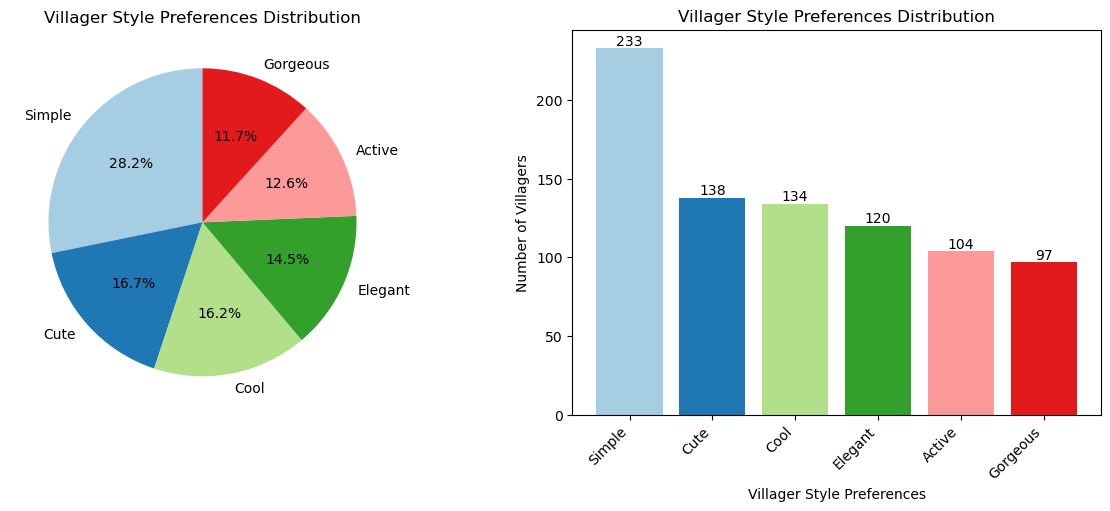

In [15]:
# Melt the DataFrame to consolidate style_1 and style_2 into a single column 'style'
stylepreferences_df = pd.melt(villagers_df, id_vars=['name'], value_vars=['style_1', 'style_2'], var_name='style_type', value_name='style')

# Count the occurrences of each style
style_counts = stylepreferences_df['style'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Create a pie chart
axes[0].pie(style_counts, labels=style_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[0].set_title('Villager Style Preferences Distribution', pad=5)

# Create a bar chart (histogram) from the style_counts
style_bars = axes[1].bar(style_counts.index, style_counts.values, color=plt.cm.Paired.colors)

# Add labels and title
axes[1].set_xlabel('Villager Style Preferences')
axes[1].set_ylabel('Number of Villagers')
axes[1].set_title('Villager Style Preferences Distribution')

# Rotate x-axis labels for better readability
axes[1].set_xticks(range(len(style_counts.index)))
axes[1].set_xticklabels(style_counts.index, rotation=45, ha='right')

# Add bar labels on top
for bar in style_bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

stylepreferences_df

,name,color_pref,color
0,Ace,color_1,Aqua
1,Admiral,color_1,Black
2,Agent S,color_1,Blue
3,Agnes,color_1,Pink
4,Al,color_1,Red
...,...,...,...
821,Wolfgang,color_2,Green
822,Yuka,color_2,Yellow
823,Zell,color_2,Gray
824,Zoe,color_2,White


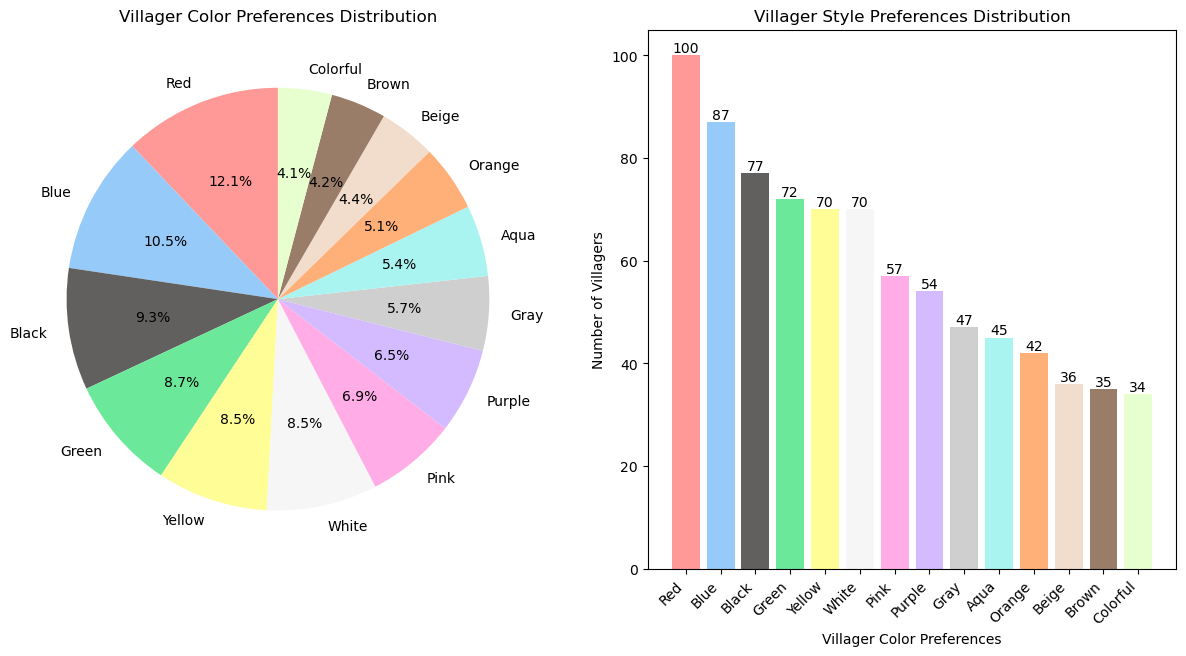

In [16]:
# Melt the DataFrame to consolidate color_1 and color_2 into a single column 'color'
colorpreferences_df = pd.melt(villagers_df, id_vars=['name'], value_vars=['color_1', 'color_2'], var_name='color_pref', value_name='color')

# Count the occurrences of each style
color_counts = colorpreferences_df['color'].value_counts()

# Specify your list of hex codes
hex_codes = ['#ff9998', '#96caf8', '#61605f', '#6ce89a', '#fffe96', '#f6f6f6', '#fface7', '#d4baff', '#cfcfcf', '#a9f4f1', '#ffb079', '#f2dccb', '#9a7d69', '#e7ffce']

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Create a pie chart with customized hex colors
axes[0].pie(color_counts, labels=color_counts.index, autopct='%1.1f%%', startangle=90, colors=hex_codes)
axes[0].set_title('Villager Color Preferences Distribution', pad=10)

# Create a bar chart (histogram) from the color_counts
color_bars = axes[1].bar(color_counts.index, color_counts.values, color=hex_codes)

# Add labels and title
axes[1].set_xlabel('Villager Color Preferences')
axes[1].set_ylabel('Number of Villagers')
axes[1].set_title('Villager Style Preferences Distribution')

# Rotate x-axis labels for better readability
axes[1].set_xticks(range(len(color_counts.index)))
axes[1].set_xticklabels(color_counts.index, rotation=45, ha='right')

# Add bar labels on top
for bar in color_bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

colorpreferences_df

,name,style_type,style
0,3D glasses,style_1,Active
1,3D glasses,style_1,Active
2,animal nose,style_1,Cute
3,ballroom mask,style_1,Elegant
4,ballroom mask,style_1,Elegant
...,...,...,...
6449,zen uniform,style_2,Simple
6450,zen uniform,style_2,Simple
6451,zen uniform,style_2,Simple
6452,zen uniform,style_2,Simple


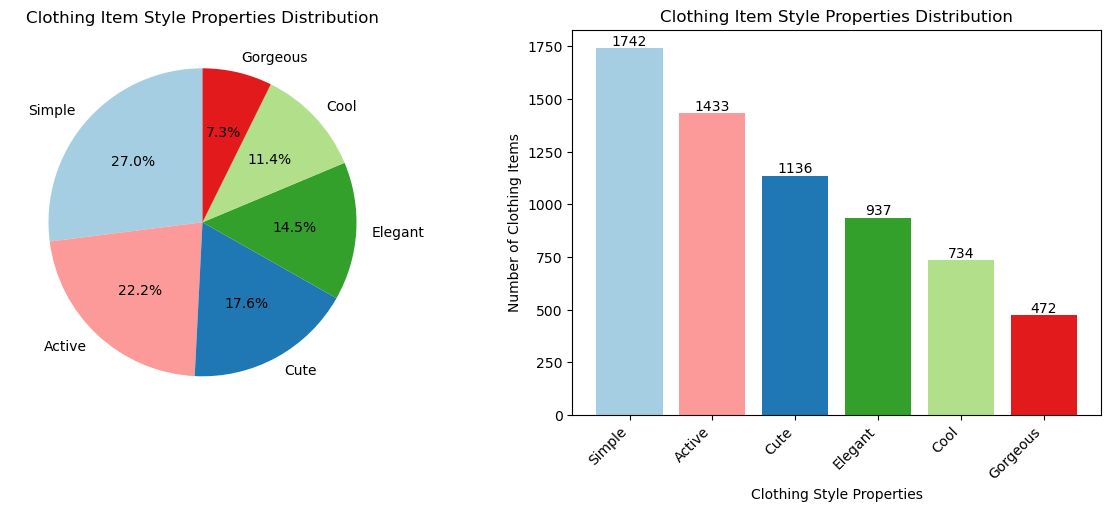

In [17]:
# Melt the DataFrame to consolidate style_1 and style_2 into a single column 'style'
styleproperties_df = pd.melt(clothing_items_df, id_vars=['name'], value_vars=['style_1', 'style_2'], var_name='style_type', value_name='style')

# Count the occurrences of each style
clothingstyle_counts = styleproperties_df['style'].value_counts()

clothing_hex_codes = ['#a6cee3', '#fb9a99', '#1f78b4', '#33a02c', '#b2df8a', '#e31a1c']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Create a pie chart
axes[0].pie(clothingstyle_counts, labels=clothingstyle_counts.index, autopct='%1.1f%%', startangle=90, colors=clothing_hex_codes)
axes[0].set_title('Clothing Item Style Properties Distribution', pad=5)

# Create a bar chart (histogram) from the clothingstyle_counts
style_bars = axes[1].bar(clothingstyle_counts.index, clothingstyle_counts.values, color=clothing_hex_codes)

# Add labels and title
axes[1].set_xlabel('Clothing Style Properties')
axes[1].set_ylabel('Number of Clothing Items')
axes[1].set_title('Clothing Item Style Properties Distribution')

# Rotate x-axis labels for better readability
axes[1].set_xticks(range(len(clothingstyle_counts.index)))
axes[1].set_xticklabels(clothingstyle_counts.index, rotation=45, ha='right')

# Add bar labels on top
for bar in style_bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

styleproperties_df

,name,color_pref,color
0,Ace,color_1,Aqua
1,Admiral,color_1,Black
2,Agent S,color_1,Blue
3,Agnes,color_1,Pink
4,Al,color_1,Red
...,...,...,...
821,Wolfgang,color_2,Green
822,Yuka,color_2,Yellow
823,Zell,color_2,Gray
824,Zoe,color_2,White


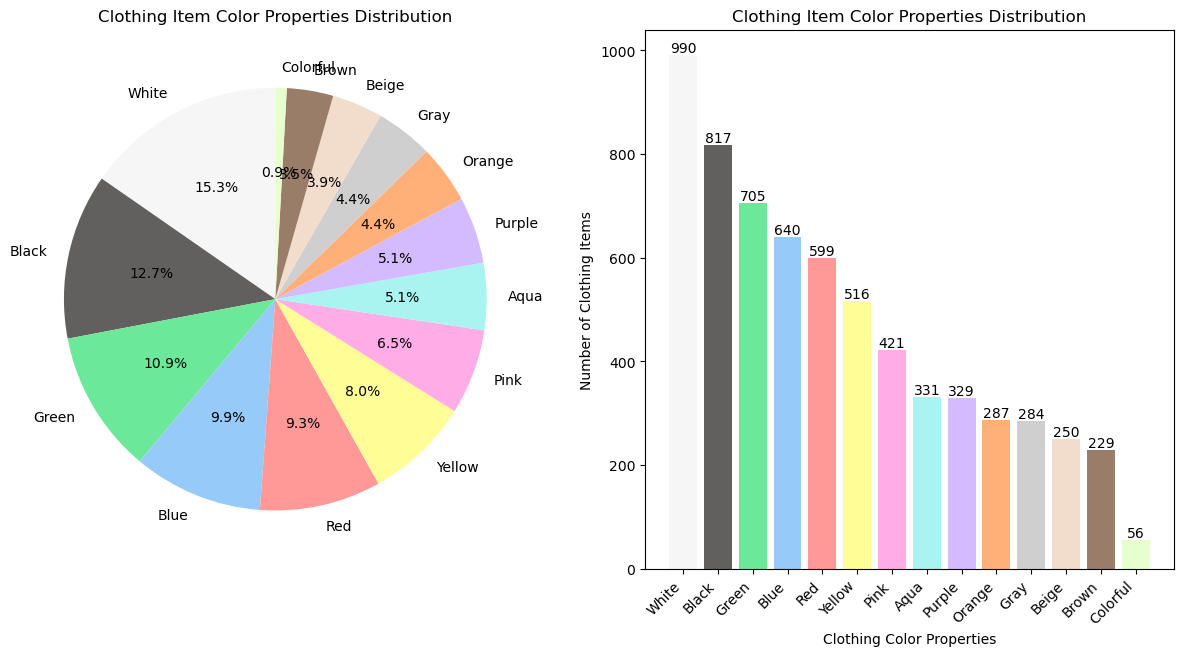

In [18]:
# Melt the DataFrame to consolidate color_1 and color_2 into a single column 'color'
colorproperties_df = pd.melt(clothing_items_df, id_vars=['name'], value_vars=['color_1', 'color_2'], var_name='color_pref', value_name='color')

# Count the occurrences of each style
clothingcolor_counts = colorproperties_df['color'].value_counts()

# Specify your list of hex codes
hex_codes2 = ['#f6f6f6', '#61605f', '#6ce89a', '#96caf8', '#ff9998', '#fffe96', '#fface7', '#a9f4f1', '#d4baff', '#ffb079', '#cfcfcf', '#f2dccb', '#9a7d69', '#e7ffce']

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Create a pie chart with customized hex colors
axes[0].pie(clothingcolor_counts, labels=clothingcolor_counts.index, autopct='%1.1f%%', startangle=90, colors=hex_codes2)
axes[0].set_title('Clothing Item Color Properties Distribution', pad=10)

# Create a bar chart (histogram) from the clothingcolor_counts
color_bars = axes[1].bar(clothingcolor_counts.index, clothingcolor_counts.values, color=hex_codes2)

# Add labels and title
axes[1].set_xlabel('Clothing Color Properties')
axes[1].set_ylabel('Number of Clothing Items')
axes[1].set_title('Clothing Item Color Properties Distribution')

# Rotate x-axis labels for better readability
axes[1].set_xticks(range(len(clothingcolor_counts.index)))
axes[1].set_xticklabels(clothingcolor_counts.index, rotation=45, ha='right')

# Add bar labels on top
for bar in color_bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

colorpreferences_df

## **Research Questions and Analysis**

**Question 1:** Can we analyze the association between Animal Crossing villagers' style and color preferences, and the clothing items they already own to improve the accuracy of clothing recommendations?

**Question 2:** Based on the identified factors influencing villagers' clothing choices, how can cluster analysis similarity measures be leveraged to quantify the relationships between their style and color preferences and the properties of available clothing items?

**Question 3:** In light of the correlations explored in Research Question 1 and the similarity measurements from Research Question 2, how can a recommendation system be optimized to provide tailored clothing suggestions for Animal Crossing villagers, emphasizing both exact and partial matches in style and color preferences?

**Question 1:** Can we analyze the association between Animal Crossing villagers' style and color preferences, and the clothing items they already own to improve the accuracy of clothing recommendations?

In [20]:
# Merge villagers_df and clothing_items_df on villagers default_clothing
villagersnew_df = villagers_df.merge(clothing_items_df, left_on='default_clothing', right_on='clothing_id', suffixes=('_villager', '_clothingitem'), how='left')

villagersnew_df
#villagersnew_df.to_csv('villagersnew_df.csv', index=False)

,name_villager,gender,personality,hobby,style_1_villager,style_2_villager,overall_style_villager,color_1_villager,color_2_villager,overall_color_villager,...,category,variation,style_1_clothingitem,style_2_clothingitem,overall_style_clothingitem,color_1_clothingitem,color_2_clothingitem,overall_color_clothingitem,villager_equippable,clothing_id
0,Ace,Male,Jock,Nature,Active,Cute,Active_Cute,Aqua,Green,Aqua_Green,...,tops,Light blue,Active,Simple,Active_Simple,Aqua,White,Aqua_White,Yes,9132
1,Admiral,Male,Cranky,Nature,Cool,Cool,Cool_Cool,Black,Blue,Black_Blue,...,tops,Dark blue,Simple,Simple,Simple_Simple,Blue,Beige,Blue_Beige,Yes,3164
2,Agent S,Female,Peppy,Fitness,Active,Simple,Active_Simple,Blue,Black,Blue_Black,...,tops,No Variation,Simple,Simple,Simple_Simple,Blue,Red,Blue_Red,Yes,12036
3,Agnes,Female,Big Sister,Play,Simple,Elegant,Simple_Elegant,Pink,White,Pink_White,...,dress-up,Pink,Elegant,Cute,Elegant_Cute,Pink,White,Pink_White,Yes,4290
4,Al,Male,Lazy,Fitness,Active,Active,Active_Active,Red,White,Red_White,...,tops,Red,Active,Active,Active_Active,Red,White,Red_White,Yes,3244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,Wolfgang,Male,Cranky,Education,Cool,Active,Cool_Active,Black,Green,Black_Green,...,tops,Brown,Cool,Cool,Cool_Cool,Brown,Beige,Brown_Beige,Yes,4207
409,Yuka,Female,Snooty,Fashion,Cool,Elegant,Cool_Elegant,Orange,Yellow,Orange_Yellow,...,tops,Orange,Simple,Elegant,Simple_Elegant,Orange,Orange,Orange_Orange,Yes,7676
410,Zell,Male,Smug,Music,Cool,Gorgeous,Cool_Gorgeous,Purple,Gray,Purple_Gray,...,tops,Black,Cool,Simple,Cool_Simple,Black,White,Black_White,Yes,3676
411,Zoe,Female,Normal,Education,Cute,Simple,Cute_Simple,Pink,White,Pink_White,...,tops,Pink,Cute,Cute,Cute_Cute,Pink,Yellow,Pink_Yellow,Yes,3248


In [21]:
own_clothinglist = villagersnew_df[['name_villager','default_clothing','name_clothingitem']].copy()
own_clothinglist.columns = ['villager','clothing_id','owned_yes']
own_clothinglist['owned_yes'] = 1

own_clothinglist

,villager,clothing_id,owned_yes
0,Ace,9132,1
1,Admiral,3164,1
2,Agent S,12036,1
3,Agnes,4290,1
4,Al,3244,1
...,...,...,...
408,Wolfgang,4207,1
409,Yuka,7676,1
410,Zell,3676,1
411,Zoe,3248,1


In [22]:
own_clothinglist.isna().sum()

villager       0
clothing_id    0
owned_yes      0
dtype: int64

In [23]:
# Sort the elements within each combination
villagersnew_df['overall_style_villager'] = villagersnew_df['overall_style_villager'].apply(lambda x: '_'.join(sorted(x.split('_'))))
villagersnew_df['overall_style_clothingitem'] = villagersnew_df['overall_style_clothingitem'].apply(lambda x: '_'.join(sorted(x.split('_'))))

# Create a new column indicating whether there's a match
villagersnew_df['style_match'] = villagersnew_df.apply(lambda row: any(style in row['overall_style_clothingitem'] for style in row['overall_style_villager'].split('_')), axis=1)

# Create a new column indicating whether there's an exact match
villagersnew_df['exact_stylematch'] = villagersnew_df.apply(lambda row: row['overall_style_clothingitem'] == row['overall_style_villager'], axis=1)

# Create a new column indicating whether there's a partial match
villagersnew_df['partial_stylematch'] = villagersnew_df.apply(lambda row: any(style in row['overall_style_clothingitem'] for style in row['overall_style_villager'].split('_')) and not row['exact_stylematch'], axis=1)

# Combine the two match columns for plotting
villagersnew_df['combined_stylematch'] = np.where(villagersnew_df['exact_stylematch'], 'Exact Match', np.where(villagersnew_df['partial_stylematch'], 'Partial Match', 'No Match'))

# Count the occurrences of each combination
count_stylefalse = villagersnew_df[villagersnew_df['style_match'] == False]['combined_stylematch'].value_counts()
count_styletrue = villagersnew_df[villagersnew_df['style_match'] == True]['combined_stylematch'].value_counts()

# Count the occurrences of each combination
count_style_match = villagersnew_df['style_match'].value_counts()

In [24]:
# Sort the elements within each combination
villagersnew_df['overall_color_villager'] = villagersnew_df['overall_color_villager'].apply(lambda x: '_'.join(sorted(x.split('_'))))
villagersnew_df['overall_color_clothingitem'] = villagersnew_df['overall_color_clothingitem'].apply(lambda x: '_'.join(sorted(x.split('_'))))

# Create a new column indicating whether there's a match
villagersnew_df['color_match'] = villagersnew_df.apply(lambda row: any(style in row['overall_color_clothingitem'] for style in row['overall_color_villager'].split('_')), axis=1)

# Create a new column indicating whether there's an exact match
villagersnew_df['exact_colormatch'] = villagersnew_df.apply(lambda row: row['overall_color_clothingitem'] == row['overall_color_villager'], axis=1)

# Create a new column indicating whether there's a partial match
villagersnew_df['partial_colormatch'] = villagersnew_df.apply(lambda row: any(style in row['overall_color_clothingitem'] for style in row['overall_color_villager'].split('_')) and not row['exact_colormatch'], axis=1)

# Combine the two match columns for plotting
villagersnew_df['combined_colormatch'] = np.where(villagersnew_df['exact_colormatch'], 'Exact Match', np.where(villagersnew_df['partial_colormatch'], 'Partial Match', 'No Match'))

# Count the occurrences of each combination
count_colorfalse = villagersnew_df[villagersnew_df['color_match'] == False]['combined_colormatch'].value_counts()
count_colortrue = villagersnew_df[villagersnew_df['color_match'] == True]['combined_colormatch'].value_counts()

# Count the occurrences of each combination
count_color_match = villagersnew_df['color_match'].value_counts()

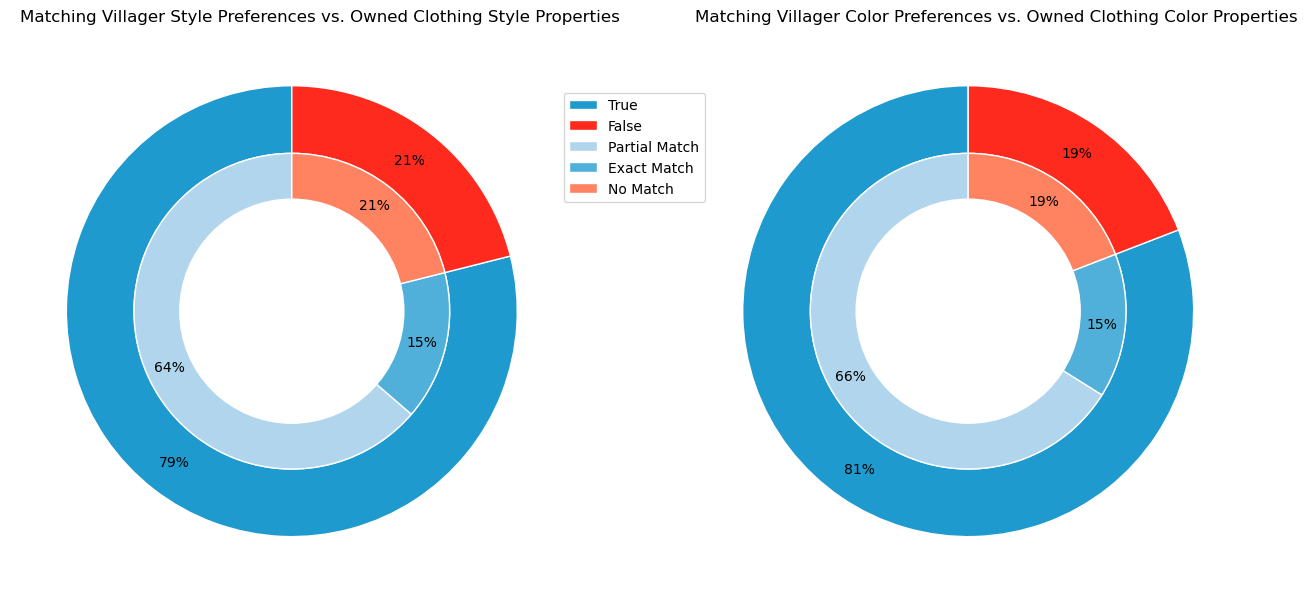

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Define colors for "True" and "False"
true_color = '#1e9ace'
false_color = '#ff2a1e'

# Create a donut plot for "True" and "False"
true_false_pie, _, true_false_pct = axes[0].pie(count_style_match,
                                         # labels=count_style_match.index,
                                          autopct='%1.0f%%',
                                          startangle=90,
                                          wedgeprops=dict(width=0.3, edgecolor='w'),
                                          colors=[true_color, false_color],
                                          pctdistance=0.85)

# Create a donut plot for "True" with "Partial Match," "Exact Match," and "No Match"
true_pie, true_text, true_pct = axes[0].pie([count_styletrue.get("Partial Match", 0), count_styletrue.get("Exact Match", 0), count_stylefalse.get("No Match", 0)],
                                      # labels=['Partial Match', 'Exact Match', 'No Match'],
                                       autopct='%1.0f%%',
                                       startangle=90,
                                       wedgeprops=dict(width=0.3, edgecolor='w'),
                                       colors=['#b0d5ec', '#51b0da', '#ff8261'], # Partial, Exact, No
                                       radius=0.7,  # Reduce the radius to create the donut effect
                                       pctdistance=0.85)  # Set labeldistance to place labels inside the wedges

# Manually adjust label distances for "True" with "Partial Match," "Exact Match," and "No Match"
label_distances = [0.15, 0.15, 0.2]

# Iterate over each text label and its corresponding distance
for i, (text, distance) in enumerate(zip(true_text, label_distances)):
    x, y = text.get_position()

    # Adjust y-coordinate for the No Match
    if i == 2:
        y += 0.7

    # Apply the adjusted position
    x = distance * x
    y = distance * y
    text.set_position((x, y))

# Add a circle in the center to make it a donut
centre_circle = plt.Circle((0, 0), 0.5, facecolor='white', linewidth=0.8)
axes[0].add_patch(centre_circle)

# Set labels and title
style_title = axes[0].set_title('Matching Villager Style Preferences vs. Owned Clothing Style Properties')
style_title.set_position([0.55, 1.05])

# Set legend with custom handles and adjust its position
axes[0].legend(['True', 'False', 'Partial Match', 'Exact Match', 'No Match'], loc='upper left', bbox_to_anchor=(0.97, 0.9))

# Create a donut plot for "True" and "False"
true_false_pie, _, true_false_pct = axes[1].pie(count_color_match,
                                         # labels=count_style_match.index,
                                          autopct='%1.0f%%',
                                          startangle=90,
                                          wedgeprops=dict(width=0.3, edgecolor='w'),
                                          colors=[true_color, false_color],
                                          pctdistance=0.85)

# Create a donut plot for "True" with "Partial Match," "Exact Match," and "No Match"
true_pie, true_text, true_pct = axes[1].pie([count_colortrue.get("Partial Match", 0), count_colortrue.get("Exact Match", 0), count_colorfalse.get("No Match", 0)],
                                      # labels=['Partial Match', 'Exact Match', 'No Match'],
                                       autopct='%1.0f%%',
                                       startangle=90,
                                       wedgeprops=dict(width=0.3, edgecolor='w'),
                                       colors=['#b0d5ec', '#51b0da', '#ff8261'], # Partial, Exact, No
                                       radius=0.7,  # Reduce the radius to create the donut effect
                                       pctdistance=0.85)  # Set labeldistance to place labels inside the wedges

# Manually adjust label distances for "True" with "Partial Match," "Exact Match," and "No Match"
label_distances = [0.15, 0.15, 0.2]

# Iterate over each text label and its corresponding distance
for i, (text, distance) in enumerate(zip(true_text, label_distances)):
    x, y = text.get_position()

    # Adjust y-coordinate for the No Match
    if i == 2:
        y += 0.7

    # Apply the adjusted position
    x = distance * x
    y = distance * y
    text.set_position((x, y))

# Add a circle in the center to make it a donut
centre_circle = plt.Circle((0, 0), 0.5, facecolor='white', linewidth=0.8)
axes[1].add_patch(centre_circle)

# Set labels and title
color_title = axes[1].set_title('Matching Villager Color Preferences vs. Owned Clothing Color Properties')
color_title.set_position([0.55, 1.05])

# Set legend with custom handles and adjust its position
# axes[1].legend(['True', 'False', 'Partial Match', 'Exact Match', 'No Match'], loc='upper left', bbox_to_anchor=(0.9, 1))


**Question 2:** Based on the identified factors influencing villagers' clothing choices, how can cluster analysis similarity measures be leveraged to quantify the relationships between their style and color preferences and the properties of available clothing items?

In [26]:
# Extract relevant features
villagers_features = villagers_df[['style_1', 'style_2', 'color_1', 'color_2']].copy()
clothing_items_features = clothing_items_df[['style_1', 'style_2', 'color_1', 'color_2']].copy()

# Combine style and color preferences into sets for each villager and clothing item
villagers_features['styles'] = villagers_features[['style_1', 'style_2']].apply(set, axis=1)
villagers_features['colors'] = villagers_features[['color_1', 'color_2']].apply(set, axis=1)

clothing_items_features['styles'] = clothing_items_features[['style_1', 'style_2']].apply(set, axis=1)
clothing_items_features['colors'] = clothing_items_features[['color_1', 'color_2']].apply(set, axis=1)

# Get the unique styles and colors across all villagers and clothing items
all_styles = set.union(*villagers_features['styles'], *clothing_items_features['styles'])
all_colors = set.union(*villagers_features['colors'], *clothing_items_features['colors'])

# Create new one-hot encoded columns for styles and colors
for style in all_styles:
    villagers_features[f'style_{style}'] = villagers_features['styles'].apply(lambda s: 1 if style in s else 0)
    clothing_items_features[f'style_{style}'] = clothing_items_features['styles'].apply(lambda s: 1 if style in s else 0)

for color in all_colors:
    villagers_features[f'color_{color}'] = villagers_features['colors'].apply(lambda s: 1 if color in s else 0)
    clothing_items_features[f'color_{color}'] = clothing_items_features['colors'].apply(lambda s: 1 if color in s else 0)

# Drop intermediate columns
villagers_features_encoded = villagers_features.drop(['styles', 'colors', 'style_1', 'style_2', 'color_1', 'color_2'], axis=1)
clothing_items_features_encoded = clothing_items_features.drop(['styles', 'colors', 'style_1', 'style_2', 'color_1', 'color_2'], axis=1)

print(clothing_items_features_encoded.shape)
print(villagers_features_encoded.shape)

villagers_features_encoded

(3227, 20)
(413, 20)


,style_Cute,style_Cool,style_Simple,style_Gorgeous,style_Elegant,style_Active,color_Black,color_Beige,color_Pink,color_Blue,color_Purple,color_Red,color_White,color_Yellow,color_Green,color_Aqua,color_Brown,color_Orange,color_Colorful,color_Gray
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0
409,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
410,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
411,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [27]:
# Calculate cosine similarity between villagers and clothing items
similarity_matrix = cosine_similarity(villagers_features_encoded, clothing_items_features_encoded)

# Convert the similarity matrix to a DataFrame for better interpretation
similarity_df = pd.DataFrame(similarity_matrix, index=villagers_df['name'], columns=clothing_items_df['clothing_id'])

similarity_df

clothing_id,4463,11020,13018,4561,11159,11218,11217,4510,11219,11086,...,8498,8499,8501,8500,14415,14954,14955,14953,14956,8204
name,,,,,,,,,,,,,,,,,,,,,
Ace,0.288675,0.288675,0.353553,0.000000,0.000000,0.000000,0.000000,0.000000,0.577350,0.000000,...,0.000000,0.000000,0.000000,0.288675,0.000000,0.00000,0.250000,0.00000,0.00000,0.577350
Admiral,0.000000,0.333333,0.408248,0.000000,0.408248,0.000000,0.000000,0.000000,0.000000,0.408248,...,0.333333,0.000000,0.000000,0.333333,0.577350,0.57735,0.288675,0.57735,0.57735,0.000000
Agent S,0.288675,0.577350,0.353553,0.000000,0.353553,0.000000,0.000000,0.000000,0.000000,0.707107,...,0.288675,0.000000,0.000000,0.288675,0.500000,0.50000,0.250000,0.50000,0.50000,0.288675
Agnes,0.288675,0.000000,0.000000,0.707107,0.353553,0.288675,0.353553,0.000000,0.000000,0.353553,...,0.000000,0.353553,0.000000,0.000000,0.250000,0.25000,0.250000,0.25000,0.25000,0.000000
Al,0.666667,0.333333,0.000000,0.408248,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,...,0.333333,0.000000,0.000000,0.000000,0.288675,0.00000,0.000000,0.00000,0.00000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wolfgang,0.288675,0.577350,0.353553,0.000000,0.353553,0.000000,0.000000,0.000000,0.288675,0.353553,...,0.288675,0.000000,0.000000,0.000000,0.250000,0.25000,0.500000,0.25000,0.50000,0.577350
Yuka,0.000000,0.000000,0.000000,0.353553,0.353553,0.000000,0.000000,0.288675,0.000000,0.000000,...,0.000000,0.000000,0.577350,0.000000,0.250000,0.50000,0.250000,0.25000,0.25000,0.000000
Zell,0.000000,0.000000,0.000000,0.000000,0.000000,0.288675,0.353553,0.288675,0.288675,0.000000,...,0.288675,0.353553,0.288675,0.288675,0.250000,0.25000,0.250000,0.50000,0.50000,0.000000


Text(0.5, 1.0, 'Cosine Similarity Heatmap for Subset of Villagers and Clothing Items')

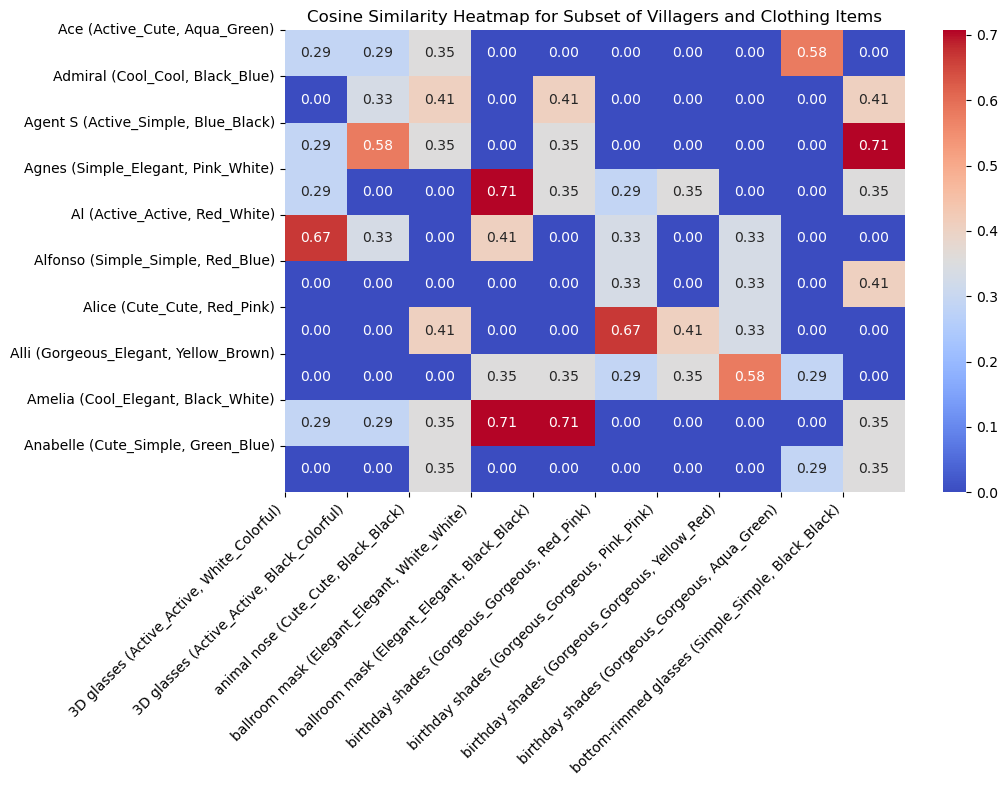

In [28]:
heatmapsimilarity_df = pd.DataFrame(similarity_matrix, index=villagers_df[['name', 'overall_style', 'overall_color']], columns=clothing_items_df[['name', 'overall_style', 'overall_color']])

# Take the first 10 rows for both villagers and clothing items for visualization
num_villagers = 10
num_clothing_items = 10

# Create a subset DataFrame using .iloc
villagers_subset_df = heatmapsimilarity_df.iloc[:num_villagers, :num_clothing_items]

# Create a heatmap using seaborn directly on the subset
plt.figure(figsize=(10, 6))
sns.heatmap(villagers_subset_df, annot=True, cmap='coolwarm', fmt=".2f")

# Tilt the x-axis labels
plt.xticks(rotation=45, ha="right")

# Customize y-axis labels
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.yticks(range(num_villagers), ['{} ({}, {})'.format(*v) for v in villagers_subset_df.index], rotation=0)

# Customize x-axis labels
plt.xticks(range(num_clothing_items), ['{} ({}, {})'.format(*c) for c in villagers_subset_df.columns], rotation=45, ha="right")

plt.title('Cosine Similarity Heatmap for Subset of Villagers and Clothing Items')

In [29]:
# Example: Similarity scores for a specific villager
selected_villager = 'Ace'
similarity_scores_for_villager = similarity_df.loc[selected_villager, :]

# Sort by descending cosine similarity
similarity_scores_for_villager.sort_values(ascending=False)

clothing_id
14297    1.000000
10899    1.000000
11042    0.866025
12441    0.866025
12451    0.866025
           ...   
8946     0.000000
12079    0.000000
3225     0.000000
11179    0.000000
11997    0.000000
Name: Ace, Length: 3227, dtype: float64

**Question 3:** In light of the correlations explored in Research Question 1 and the similarity measurements from Research Question 2, how can a recommendation system be optimized to provide tailored clothing suggestions for Animal Crossing villagers, emphasizing both exact and partial matches in style and color preferences?

In [30]:
def recommend_clothing_for_villager(villager_name, similarity_df, clothing_items_df, own_clothinglist, number_of_recommendations=10, sort_by_category=''):
    # Get the similarity scores for the specified villager
    villager_similarity = similarity_df.loc[villager_name]

    # Multiply the similarity scores with clothing items features
    recommendations = clothing_items_df.copy()
    recommendations['similarity_score'] = villager_similarity.values

    # Exclude owned items
    owned_items = own_clothinglist[own_clothinglist['villager'] == villager_name]['clothing_id'].tolist()
    recommendations = recommendations[~recommendations['clothing_id'].isin(owned_items)]

    # Exclude items with cosine similarity of 0
    recommendations = recommendations[recommendations['similarity_score'] > 0]

    # Optionally sort by category (lowercased)
    if sort_by_category.strip():  # Check if the string is not blank after stripping whitespace
        sort_by_category = sort_by_category.lower()
        recommendations = recommendations[recommendations['category'].str.lower() == sort_by_category]

    # Sort the clothing items based on similarity scores, then alphabetically in ascending order
    recommendations = recommendations.sort_values(by=['similarity_score', 'name'], ascending=[False, True])

    # Select the top N recommendations
    recommendations = recommendations.head(number_of_recommendations)

    # Reset and renumber the indices starting from 1
    recommendations.reset_index(drop=True, inplace=True)
    recommendations.index += 1

    return recommendations[['category', 'name', 'variation', 'overall_style', 'overall_color', 'clothing_id', 'similarity_score']], villager_similarity

# Example usage
villager_name = 'Ace'  # Replace with the desired villager name
number_of_recommendations = 15  # Specify the number of recommendations
sort_by_category = ''  # Specify the category you want to filter by ('tops', 'dress-up', 'accessories', or 'headwear'), or leave it as a blank string for all categories

recommendations, villager_similarity = recommend_clothing_for_villager(villager_name, similarity_df, clothing_items_df, own_clothinglist, number_of_recommendations, sort_by_category)

# Display the recommended items with similarity scores
recommendations[['category', 
                 'name', 
                 'variation',
                # 'similarity_score'
                 ]]

,category,name,variation
1,tops,Hawaiian-print apron,Mint
2,tops,kids' smock,Frog
3,headwear,acorn knit cap,Avocado
4,dress-up,glowing-moss dress,No Variation
5,headwear,glowing-moss headband,No Variation
6,headwear,glowing-moss pointed cap,No Variation
7,dress-up,leaf-egg outfit,No Variation
8,headwear,leaf-egg shell,No Variation
9,tops,music-fest shirt,Light blue
10,headwear,outdoor hat,Light blue


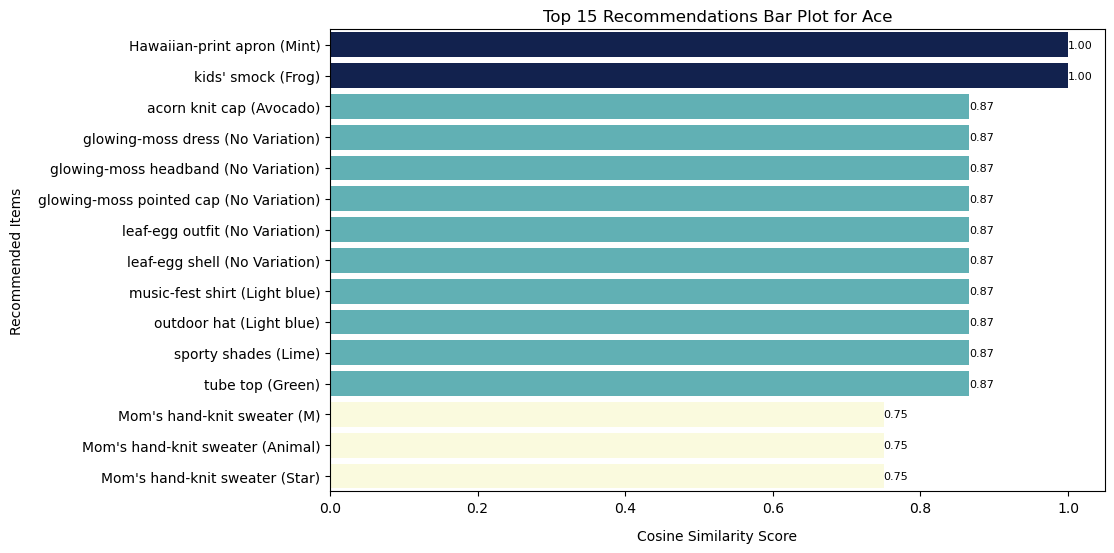

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already defined recommendations, number_of_recommendations, villager_name, and clothing_items_df

# Assuming your recommendations DataFrame has the columns: 'name', 'similarity_score', 'variation'
heatmap_final_recc = recommendations[['name', 'similarity_score', 'variation']]

# Sort the recommendations by similarity_score in descending order
heatmap_final_recc = heatmap_final_recc.sort_values(by='similarity_score', ascending=False)

# Create a list of labels with both clothing item name and variation
labels = [f"{name} ({variation})" for name, variation in heatmap_final_recc[['name', 'variation']].values]

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='similarity_score', y=labels, data=heatmap_final_recc, hue='similarity_score', dodge=False, palette='YlGnBu')

# Add annotations to the bars
for index, value in enumerate(heatmap_final_recc['similarity_score']):
    barplot.text(value, index, f'{value:.2f}', ha='left', va='center', fontsize=8)

plt.title(f'Top {number_of_recommendations} Recommendations Bar Plot for {villager_name}')
plt.xlabel('Cosine Similarity Score', labelpad=10)
plt.ylabel('Recommended Items', labelpad=10)

# Remove the legend
barplot.legend_.remove()

## **Findings**

**Question 1:** Can we analyze the association between Animal Crossing villagers' style and color preferences, and the clothing items they already own to improve the accuracy of clothing recommendations?

* **Purpose:** The donut plots serve as a visual representation to assess the alignment between villagers' style preferences and owned clothing style properties (aka clothing items the villagers already own), as well as between villagers' color preferences and owned clothing color properties. The outer circle presents a binary comparison, indicating whether there is a match (True) or not (False) between style preferences and properties. This analysis extends to color preferences and properties as well. By utilizing this visual tool, one can quickly grasp the overall concordance or dissonance between these key elements in the virtual wardrobe system. The inner circle, differentiating between Partial Match and Exact Match within the True category, offers a nuanced understanding of the degree to which style and color preferences align with owned clothing items.

- **Insights:**
  - **Style Preferences vs. Style Properties:**
    - *True (Match):*
      - *Exact Match:* Pinpoints instances where villagers' style preferences precisely align with owned clothing style properties.
      - *Partial Match:* Identifies cases where there is some degree of correspondence between style preferences and properties, allowing for a more detailed exploration of the matching spectrum.
    - *False (No Match):* Highlights situations where style preferences and clothing style properties do not align
  - **Color Preferences vs. Color Properties:**
    - *True (Match):*
      - *Exact Match:* Illustrates scenarios where villagers' color preferences perfectly coincide with owned clothing color properties.
      - *Partial Match:* Distinguishes situations where there is a partial agreement between color preferences and properties
    - *False (No Match):* Highlights situations where color preferences and clothing color properties do not align

![image info](https://raw.githubusercontent.com/yepzoey/dsc207finalproject/main/images/donutplots.png)

**Interpretation:**

**Style Preferences vs. Style Properties:**
- **False (No Match):** 21%
- **True (Match):** 79%
  - **Partial Match:** 64%
  - **Exact Match:** 15%

The results indicate a strong association between villagers' style preferences and the clothing items they already own. The majority (79%) of the cases show a match between style preferences and style properties, with a significant proportion falling into the "Partial Match" category (64%). This suggests that while not every style property of a villager's owned clothing items perfectly aligns with their style preferences, there's a substantial degree of correspondence, contributing to a meaningful association.

**Color Preferences vs. Color Properties:**
- **False (No Match):** 19%
- **True (Match):** 81%
  - **Partial Match:** 66%
  - **Exact Match:** 15%

Similar to style preferences, there is a robust association between villagers' color preferences and the colors of their owned clothing items. The majority (81%) of cases exhibit a match, with a notable percentage falling into the "Partial Match" category (66%). This underscores that, while not every color preference perfectly aligns with owned items, there is a substantial overlap, supporting the association between color preferences and clothing color properties.

**Overall Implications:**

The data strongly supports the idea that analyzing the association between Animal Crossing villagers' style and color preferences and their owned clothing items can indeed improve the accuracy of clothing recommendations. The prevalence of partial matches suggests that, while not every clothing item precisely matches a villager's preferences, there is a considerable degree of alignment. This insight is crucial for refining the virtual wardrobe and enhancing the accuracy of recommendations, as it acknowledges and leverages the existing correspondences between preferences and owned items. The relatively balanced distribution between style and color preferences further indicates that both aspects are equally important when considering clothing recommendations.

In conclusion, the donut plot results provide a positive answer to the research question, suggesting that understanding and utilizing the association between style and color preferences and owned clothing items can enhance the accuracy of clothing recommendations in Animal Crossing.

**Question 2:** Based on the identified factors influencing villagers' clothing choices, how can cluster analysis similarity measures be leveraged to quantify the relationships between their style and color preferences and the properties of available clothing items?

- **Purpose:** The cosine similarity heatmap serves as a comprehensive visual tool to quantify the relationships between Animal Crossing villagers' style and color preferences and the properties of available clothing items. Given the vast dataset with over 3000 clothing items and 413 villagers, the heatmap offers a condensed representation focusing on a subset of 10 villagers and 10 clothing items. The y-axis displays the names of 10 villagers along with their overall_style and overall_color preferences, while the x-axis showcases 10 clothing items, each denoted with the clothing name and the corresponding overall_style and overall_color properties. The numbers within each square/box represent cosine similarity scores, derived from one-hot encoding villagers' style and color preferences as well as each clothing item's style and color properties. The purpose of using cosine similarity in this context is to handle the sparsity of the data, providing a robust measure of similarity between preferences and properties while accommodating the diverse range of clothing options.

- **Insights:**
    - **Quantifying Relationships:** The heatmap allows for a detailed examination of the cosine similarity scores, providing insights into the degree of similarity between villagers' preferences and clothing item properties. Higher scores indicate a stronger resemblance, while lower scores suggest greater dissimilarity.
    
    - **Identifying Influential Factors:** By observing the heatmap, one can identify key factors influencing villagers' clothing choices. Clusters of high cosine similarity scores may reveal patterns where certain clothing items align closely with specific villagers' style and color preferences, shedding light on influential factors guiding their choices.

    - **Cluster Analysis Leveraging:** The cosine similarity heatmap lays the groundwork for leveraging cluster analysis to further understand the relationships between style and color preferences and clothing item properties. Clusters of high similarity scores may indicate groups of clothing items that share common attributes, helping to categorize and recommend items based on the identified factors influencing villagers' clothing choices.

**Rationale Behind Cosine Similarity:**

In the context of this project, cosine similarity is employed due to the sparsity of the data resulting from one-hot encoding villagers' style and color preferences and clothing items' style and color properties. Cosine similarity is well-suited for sparse datasets as it measures the cosine of the angle between two vectors, providing a robust measure of similarity while accommodating the absence of certain preferences or properties. A high cosine similarity score (closer to 1) indicates a strong alignment, while a low score (closer to 0) suggests a greater dissimilarity. This makes cosine similarity an effective metric for quantifying the relationships between villagers' style and color preferences and the properties of available clothing items in a meaningful and interpretable way.

![image info](https://raw.githubusercontent.com/yepzoey/dsc207finalproject/main/images/subset_heatmapsimilarity_df.png)

**Interpretation and Conclusion**

The cosine similarity heatmap offers valuable insights into the relationships between villagers' style and color preferences and the properties of available clothing items. The heatmap serves as a powerful tool to quantify the degree of alignment between individual villagers and specific clothing items, leveraging cluster analysis similarity measures.

**Key Insights:**

1. **Precision in Style Matching:** The heatmap effectively captures instances of high cosine similarity scores, indicating precise matches between villagers' style preferences and the corresponding style properties of clothing items. For example, Amelia's 'Cool_Elegant' style and Black_white color preferences aligns well with the 'Elegant_Elegant' and 'Black_White' properties of the 'ballroom mask,' resulting in a cosine similarity score of 0.707106781.

2. **Partial Matches Signifying Nuanced Recommendations:** Lower cosine similarity scores, as observed in cases like Ace's 'Active_Cute' preferences and the '3D glasses' with a score of 0.288675135, highlight the system's ability to suggest items that partially align with a villager's style and color preferences. Ace's Active and Cute style preferences and Aqua and Green color preferences only partially overlap with the Active properties of the "3D glasses." This nuanced approach ensures a broader range of suitable recommendations.

In conclusion, the cosine similarity heatmap serves as a precise and insightful visualization for checking and quantifying the relationships between villagers' style and color preferences and the properties of available clothing items. It offers a nuanced perspective on the factors influencing villagers' clothing choices, allowing us to create a clothing recommendation system for Animal Crossing villagers.

**Question 3:** In light of the correlations explored in Research Question 1 and the similarity measurements from Research Question 2, how can a recommendation system be optimized to provide tailored clothing suggestions for Animal Crossing villagers, emphasizing both exact and partial matches in style and color preferences?

- **Purpose:** The horizontal bar plot serves as a visual representation to address Research Question 3. The plot specifically visualizes the Top N Recommendations for an inputted villager name generated by the clothing recommendation system code. The y-axis lists all N recommended clothing items, ordered by their cosine similarity scores, reflecting how well they match the villager's style and color preferences. The x-axis indicates the cosine similarity score, ranging from 0 to 1, with higher scores indicating a closer match to the villager's preferences.

- **Insights:**
    - **Tailored Recommendations:** The horizontal bar plot provides a straightforward overview of the Top N Recommendations, emphasizing both exact and partial matches in style and color preferences. The ordered list allows users to quickly identify the most highly recommended clothing items based on the villager's preferences.

    - **Cosine Similarity Scores:** The x-axis, representing cosine similarity scores, offers insights into the degree of alignment between the recommended items and the villager's preferences.

    - **Color Grouping:** Grouping recommended items by color based on cosine similarity scores adds an additional layer of insight. This visual grouping allows users to discern patterns in color recommendations, aiding in the optimization of the recommendation system to consider both style and color preferences.

**Optimization Strategy:**

In optimizing the recommendation system, the horizontal bar plot highlights the significance of considering both exact and partial matches in style and color preferences. The Top N Recommendations allow for a tailored approach, ensuring that the recommended items align closely with the villager's preferences. By incorporating cosine similarity scores, the system emphasizes a spectrum of recommendations, from precise matches to those with varying degrees of resemblance. The color grouping further refines the suggestions, enhancing the user experience by presenting visually cohesive recommendations. This optimization strategy aims to strike a balance, catering to the nuanced preferences of Animal Crossing villagers and providing a more personalized and satisfying recommendation system.


![image info](https://raw.githubusercontent.com/yepzoey/dsc207finalproject/main/images/recommendations_barh.png)

**Conclusion:**

In response to Research Question 3, the example results demonstrate that the recommendation system effectively balances both exact and partial matches in style and color preferences. The optimization strategy, as reflected in the horizontal bar plot, showcases the system's ability to tailor suggestions to individual villagers like Ace, providing a personalized and satisfying experience.

**Key Insights:**

1. **Emphasis on Exact Matches:** The system accurately identifies and recommends items with precise matches to Ace's style and color preferences, as seen with the "Hawaiian-print apron" and "Kids' smock" (cosine similarity scores of 1.0).

2. **Importance of Partial Matches:** The majority of recommendations are partial matches, demonstrating the system's capability to suggest items that closely align with Ace's preferences, even if not an exact match. Items like the "Acorn knit cap" and "Glowing-moss dress" exemplify this nuanced approach.

3. **Color Grouping:** The color grouping strategy enhances the user experience, providing a visual pattern for us to quickly identify and explore items that match the villager's style and specific color preferences. This approach contributes to the optimization of the recommendation system, ensuring a comprehensive and visually coherent set of suggestions.

4. **Diversity in Recommendations:** The presence of various clothing categories illustrates the system's consideration of a broad range of options, ensuring a well-rounded selection. The system is also able to filtered by category in case the user/player only wanted to gift accessories or actual tops.

**Optimization Strategy:**

The optimization strategy implemented in the recommendation system involves prioritizing both exact and partial matches, allowing for a nuanced understanding of individual preferences. The system successfully leverages cosine similarity scores to quantify the alignment between villagers' preferences and available clothing items. A score of 1.0 signifies an exact match, while scores lower than 1 represent partial matches to varying degrees, as explored in Research Question 2 with the heatmap. This approach ensures that the recommendation algorithm is robust, providing tailored suggestions that align with the unique style and color preferences of Animal Crossing villagers. Overall, the optimization strategy contributes to an improved user experience, making the recommendation system a valuable tool for enhancing virtual wardrobe choices in the game and befriending the cute villagers on your ideal island getaway!


**Limitations:**

1. **Sparse Data Representation:** The one-hot encoding of villagers' style and color preferences and clothing items' style and color properties results in sparse data. While cosine similarity is an appropriate metric for such sparse data, there might be nuances not captured by the encoding. Certain combinations of preferences and properties could be underrepresented, potentially impacting the accuracy of similarity scores.

2. **Assumptions in Style and Color Preferences:** The assumption that style and color preferences can be adequately represented by a one-hot encoding approach may oversimplify the complexity of individual preferences. Villagers in Animal Crossing may have nuanced tastes that extend beyond the selected style and color categories, potentially leading to underestimation or oversimplification of their actual preferences.